In [7]:
import torch
import MySQLdb
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.utils.data.sampler as smp
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import IPython.display
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import dataset
import dataLoader
import configure as cf
import plot_utils as utils
import train_function as train
import resnet as modified_resnet

In [3]:
#define transform function, define trainset and valset
#ResNet50 requires the input size of 256*256*3

imgTransform = transforms.Compose([transforms.Scale(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010))])

# +---------+
# | label   |
# +---------+
# | food    |
# | inside  |
# | outside |
# | menu    |
# | drink   |
# +---------+

trainLoader, valLoader = dataLoader.get_train_valid_loader(cf.photo_url,50,32,'food',imgTransform,0.1,-1)

  0%|          | 0/47799 [00:00<?, ?it/s]

inside
After search photo, find result: 47799
Start search stars for each photo.


100%|██████████| 47799/47799 [00:06<00:00, 6894.26it/s]


In [ ]:
#define learningRate
learningRate = 1e-3 

# Definition of our network.
network = models.resnet50(pretrained = False)
network.fc = nn.Linear(512*4, 1)  

#Definition of our loss.
#The MSELoss function 
criterion = nn.MSELoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

result = []
# Train the previously defined model.
result = train.train_model(network, criterion, optimizer, trainLoader,
                           valLoader, n_epochs = 10, use_gpu = True, batch_size = 50)

print result

utils.plot_loss(result[2],result[3])
utils.plot_accuracy(result[0],result[1])

In [4]:
print result

[[50.59028414298808, 56.942254812098994, 57.802933088909256, 58.51054078826765, 59.07791017415215, 59.48670944087993, 60.30430797433547, 60.69019248395967, 61.19981668194317, 61.81209899175069], [57.47933884297521, 58.768595041322314, 58.925619834710744, 59.743801652892564, 59.94214876033058, 60.93388429752066, 61.099173553719005, 61.19834710743802, 61.917355371900825, 61.85123966942149], [0.24833597543955832, 0.008686473441440834, 0.00835445577881404, 0.008081429607954514, 0.007793153083237019, 0.0075661753653441955, 0.0073240602573705965, 0.0071899474380105926, 0.007033700810917794, 0.006900990841095869], [0.009241602208988725, 0.008413364990683627, 0.00818081969195161, 0.008160584977835663, 0.00761998611787134, 0.007246011869966491, 0.007027069205833861, 0.006997803581401336, 0.0068012114743555875, 0.006864086703574362]]


In [ ]:
result = train.train_model(network, criterion, optimizer, trainLoader,
                           valLoader, n_epochs = 10, use_gpu = True, batch_size = 50)

print result

utils.plot_loss(result[2],result[3])
utils.plot_accuracy(result[0],result[1])

In [6]:
torch.save(network.state_dict(), "./test_save1")

In [6]:
load_model = models.resnet50(pretrained = False)
load_model.fc = nn.Linear(512*4, 1)  
load_model.load_state_dict(torch.load("./test_save1"))

In [3]:
#define transform function, define trainset and valset
#ResNet50 requires the input size of 256*256*3

imgTransform = transforms.Compose([transforms.Scale(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010))])

trainLoader, valLoader = dataLoader.get_train_valid_loader(cf.photo_url,50,32,'food',imgTransform,0.1,-1)

#define learningRate
learningRate = 1e-3 

#Definition of our loss.
#The MSELoss function 
criterion = nn.MSELoss()

result = []

food


  1%|          | 981/121267 [00:00<00:12, 9809.00it/s]

After search photo, find result: 121267
Start search stars for each photo.


100%|██████████| 121267/121267 [00:15<00:00, 7914.55it/s]


[[61.22364802933089, 61.29605866177818, 61.27956003666361, 61.21906507791017, 61.37030247479377, 61.34372135655362, 61.16865261228231, 61.384967919340056, 61.15673693858845, 61.197066911090744], [61.16528925619835, 61.31404958677686, 61.06611570247934, 61.51239669421488, 61.570247933884296, 61.05785123966942, 60.95867768595041, 61.48760330578512, 60.53719008264463, 61.289256198347104], [0.006820960992197724, 0.006835431809085537, 0.006831768377181262, 0.00682942104328673, 0.0068133639818096685, 0.006821668210185853, 0.00682588693884728, 0.006821696158536086, 0.006829591031117138, 0.0068080077499943405], [0.006960323440634515, 0.006904581506882817, 0.006944914649833332, 0.0068966846131096205, 0.00688632425074735, 0.0069271129739185994, 0.006995650783550641, 0.006902517751475011, 0.007050081173743099, 0.006923864389007742]]


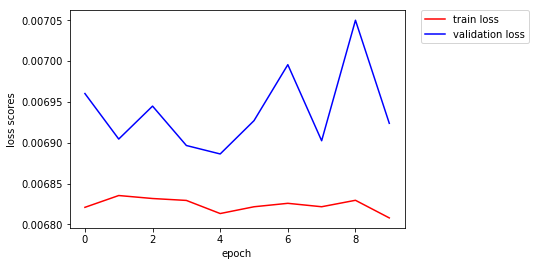

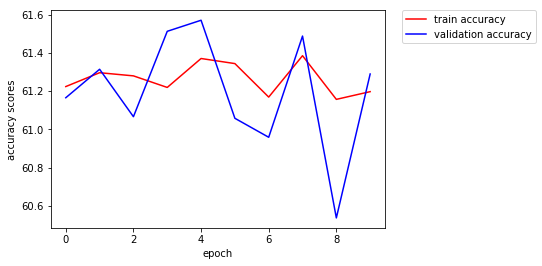

In [ ]:
# Train the previously defined model.
result = train.train_model(load_model, criterion, optimizer, trainLoader,
                           valLoader, n_epochs = 10, use_gpu = True, batch_size = 50)

print result

utils.plot_loss(result[2],result[3])
utils.plot_accuracy(result[0],result[1])

In [5]:
new_model = modified_resnet.resnet50(pretrained = False)
new_model.fc = nn.Linear(512*4, 1)  

In [10]:
# Definition of optimization strategy.
optimizer = optim.SGD(new_model.parameters(), lr = learningRate)
# Train the previously defined model.
result = train.train_model(new_model, criterion, optimizer, trainLoader,
                           valLoader, n_epochs = 10, use_gpu = True, batch_size = 50)

[[37.53070577451879, 47.012832263978005, 49.99816681943172, 51.400549954170486, 52.26947754353804, 53.3263061411549, 53.84051329055912, 54.45737855178735, 54.7846012832264, 55.26306141154904], [58.47107438016529, 58.72727272727273, 57.81818181818182, 58.6198347107438, 58.710743801652896, 58.82644628099174, 59.00826446280992, 59.21487603305785, 59.35537190082645, 59.20661157024794], [0.7924029039552625, 0.017299166569515283, 0.012619056021888578, 0.011223045536184617, 0.01051591155755203, 0.010013197700738033, 0.009728293443605728, 0.0094627917163914, 0.009295892098783683, 0.009120967970677848], [0.009236879666482121, 0.009257906656866231, 0.009105823924226208, 0.00877163291100628, 0.008670142727696206, 0.008852720538939327, 0.008435359301645894, 0.008334465658615443, 0.008402720652828531, 0.00847578369881496]]


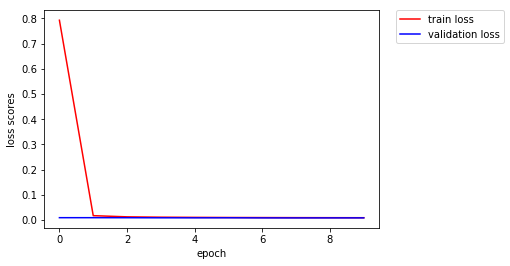

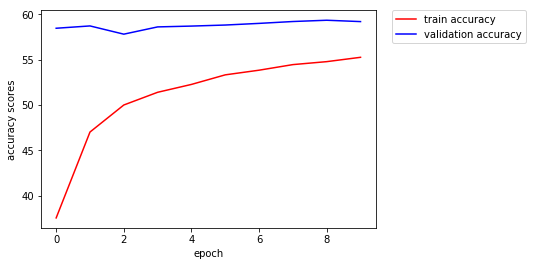

In [11]:
print result

utils.plot_loss(result[2],result[3])
utils.plot_accuracy(result[0],result[1])

In [13]:
torch.save(new_model.state_dict(), "./resnet_dropout_train1")

In [6]:
new_pretrained_model = modified_resnet.resnet50(pretrained = True)
new_pretrained_model.fc = nn.Linear(512*4, 1)  

# Definition of optimization strategy.
optimizer = optim.SGD(new_pretrained_model.parameters(), lr = learningRate)
# Train the previously defined model.
result = train.train_model(new_pretrained_model, criterion, optimizer, trainLoader,
                           valLoader, n_epochs = 10, use_gpu = True, batch_size = 50)

In [7]:
torch.save(new_pretrained_model.state_dict(), "./resnet_pretrained_dropout_train1")

In [8]:
more_result = train.train_model(new_pretrained_model, criterion, optimizer, trainLoader,
                           valLoader, n_epochs = 10, use_gpu = True, batch_size = 50)

In [9]:
print result
print more_result

[[2777.2331653687584, 3023.453962437013, 3132.8905176362805, 3199.770957398076, 3256.0696289509847, 3310.7191937700413, 3378.332569857994, 3435.639028859368, 3488.089784699954, 3552.8172240036647], [2976.543209876543, 3174.074074074074, 3205.349794238683, 3165.8436213991768, 3230.864197530864, 3193.0041152263375, 3248.559670781893, 3207.4074074074074, 3230.864197530864, 3041.5637860082306], [0.008901026196347585, 0.007194909926445849, 0.00666420638889047, 0.006370561353172544, 0.006099512662284425, 0.005833839959201192, 0.005555438688391944, 0.005321527972790104, 0.0050980422955849754, 0.0048301351949995965], [0.007082599279555408, 0.006501448477102705, 0.00658286860905403, 0.007035237006412065, 0.006695501459531548, 0.006360709769420388, 0.006247441979232898, 0.006287111829627644, 0.006302056108131881, 0.006829523227431558]]
[[3617.8195144296837, 3710.0320659642693, 3794.686211635364, 3878.7906550618413, 3960.42143838754, 4054.6037562986717, 4144.938158497481, 4231.1497938616585, 4274

In [10]:
torch.save(new_pretrained_model.state_dict(), "./resnet_pretrained_dropout_train2")

In [14]:
def process_result(result) :
    new = []
    for i in range(4):
        if(i<2) :
            temp = []
            for var in result[i]:
                temp.append(var/50)
            new.append(temp)
        else:
            temp = []
            for var in result[i] :
                temp.append(var * 50)
            new.append(temp)
    return new

In [16]:
new_result = process_result(result)
print new_result
new_more_result = process_result(more_result)
print new_more_result

[[55.54466330737517, 60.469079248740265, 62.65781035272561, 63.99541914796152, 65.1213925790197, 66.21438387540083, 67.56665139715987, 68.71278057718736, 69.76179569399909, 71.05634448007329], [59.53086419753086, 63.48148148148148, 64.10699588477365, 63.31687242798353, 64.61728395061728, 63.86008230452675, 64.97119341563786, 64.14814814814815, 64.61728395061728, 60.83127572016461], [0.4450513098173793, 0.35974549632229247, 0.3332103194445235, 0.3185280676586272, 0.30497563311422127, 0.2916919979600596, 0.27777193441959724, 0.2660763986395052, 0.2549021147792488, 0.24150675974997982], [0.35412996397777036, 0.3250724238551353, 0.3291434304527015, 0.35176185032060325, 0.3347750729765774, 0.31803548847101937, 0.3123720989616449, 0.3143555914813822, 0.3151028054065941, 0.3414761613715779]]
[[72.35639028859367, 74.20064131928538, 75.89372423270729, 77.57581310123683, 79.2084287677508, 81.09207512597344, 82.89876316994962, 84.62299587723317, 85.49152542372882, 86.4196060467247], [63.909465020

## Try train other dataset here

In [4]:
# +---------+
# | label   |
# +---------+
# | food    |
# | inside  |
# | outside |
# | menu    |
# | drink   |
# +---------+

In [10]:
#define learningRate
learningRate = 1e-3 

#Definition of our loss.
#The MSELoss function 
criterion = nn.MSELoss()

In [5]:
trainLoader, valLoader = dataLoader.get_train_valid_loader(cf.photo_url,50,32,'inside',imgTransform,0.1,-1)

inside


  2%|▏         | 992/47799 [00:00<00:04, 9909.00it/s]

After search photo, find result: 47799
Start search stars for each photo.


100%|██████████| 47799/47799 [00:06<00:00, 7540.18it/s]


In [11]:
new_pretrained_model = modified_resnet.resnet50(pretrained = True)
new_pretrained_model.fc = nn.Linear(512*4, 1)  

# Definition of optimization strategy.
optimizer = optim.SGD(new_pretrained_model.parameters(), lr = learningRate)
# Train the previously defined model.
result = train.train_model(new_pretrained_model, criterion, optimizer, trainLoader,
                           valLoader, n_epochs = 10, use_gpu = True, batch_size = 50)

A Jupyter Widget

IOError: Traceback (most recent call last):
  File "/home/razqtest1/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "dataset.py", line 46, in __getitem__
    image = Image.open(img_address).convert('RGB')
  File "/home/razqtest1/anaconda2/lib/python2.7/site-packages/PIL/Image.py", line 2477, in open
    fp = builtins.open(filename, "rb")
IOError: [Errno 2] No such file or directory: u'/media/raz/CV/yelp_photos.tar/photos/J9M5xQDCXDaPrNfSdVuqjw.jpg'


In [ ]:
torch.save(new_pretrained_model.state_dict(), "./resnet_inside")